# Lab 11: Deep Learning for Network Performance Prediction using RNNs and LSTMs

This lab focuses on implementing and comparing different Recurrent Neural Network architectures for predicting cellular network performance metrics. Learners will gain practicle experience in:
- Processing and preparing time-series network data
- Implementing basic RNN, LSTM, and GRU models
- Understanding the advantages and limitations of each architecture
- Using bidirectional LSTMs for improved prediction accuracy
- Evaluating and comparing model performance


## Data Dictionary
| Feature                      | Description                                  | Data Type | Units/Range |
|-----------------------------|----------------------------------------------|-----------|-------------|
| Timestamp                   | Time of measurement                          | datetime  | -           |
| Locality                    | Location in Bihar where data was collected   | string    | -           |
| Latitude                    | Geographic latitude                          | float     | degrees     |
| Longitude                   | Geographic longitude                         | float     | degrees     |
| Signal_Strength            | Received signal power                        | float     | dBm         |
| Signal_Quality             | Signal quality percentage                    | float     | 0-100%      |
| Data_Throughput           | Network data transmission capacity           | float     | Mbps        |
| Latency                    | Network response time                        | float     | ms          |
| Network_Type              | Type of cellular network                     | string    | 3G/4G/5G/LTE|
| BB60C_Measurement         | Signal strength from BB60C analyzer          | float     | dBm         |
| srsRAN_Measurement        | Signal strength from srsRAN                  | float     | dBm         |
| BladeRFxA9_Measurement    | Signal strength from BladeRFxA9              | float     | dBm         |


## Lab Tasks Overview
1. **Data Loading and Initial Analysis**
   - Load and examine the dataset
   - Check for missing values
   - Analyze basic statistics
   
2. **Data Preprocessing**
   - Convert timestamps
   - Handle missing values
   - Feature scaling
   - Sequence preparation
   
3. **Basic RNN Implementation**
   - Create sequences
   - Build simple RNN model
   - Train and evaluate
   
4. **LSTM Implementation**
   - Build LSTM architecture
   - Compare with basic RNN
   
5. **Advanced Implementations**
   - Implement GRU
   - Create Bidirectional LSTM
   - Performance comparison


Task: 1. **Data Loading and Initial Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
# Load the dataset
def load_and_analyze_data(file_path):
    # Read the data
    df = pd.read_csv(file_path)

    # Display basic information
    print("\nDataset Info:")
    print(df.info())

    # Display basic statistics
    print("\nBasic Statistics:")
    print(df.describe())

    # Check missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    return df

In [3]:
# Load the data
df = load_and_analyze_data('/content/signal_metrics.csv')



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16829 entries, 0 to 16828
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     16829 non-null  object 
 1   Locality                      16829 non-null  object 
 2   Latitude                      16829 non-null  float64
 3   Longitude                     16829 non-null  float64
 4   Signal Strength (dBm)         16829 non-null  float64
 5   Signal Quality (%)            16829 non-null  float64
 6   Data Throughput (Mbps)        16829 non-null  float64
 7   Latency (ms)                  16829 non-null  float64
 8   Network Type                  16829 non-null  object 
 9   BB60C Measurement (dBm)       16829 non-null  float64
 10  srsRAN Measurement (dBm)      16829 non-null  float64
 11  BladeRFxA9 Measurement (dBm)  16829 non-null  float64
dtypes: float64(9), object(3)
memory usage: 1.5+ M

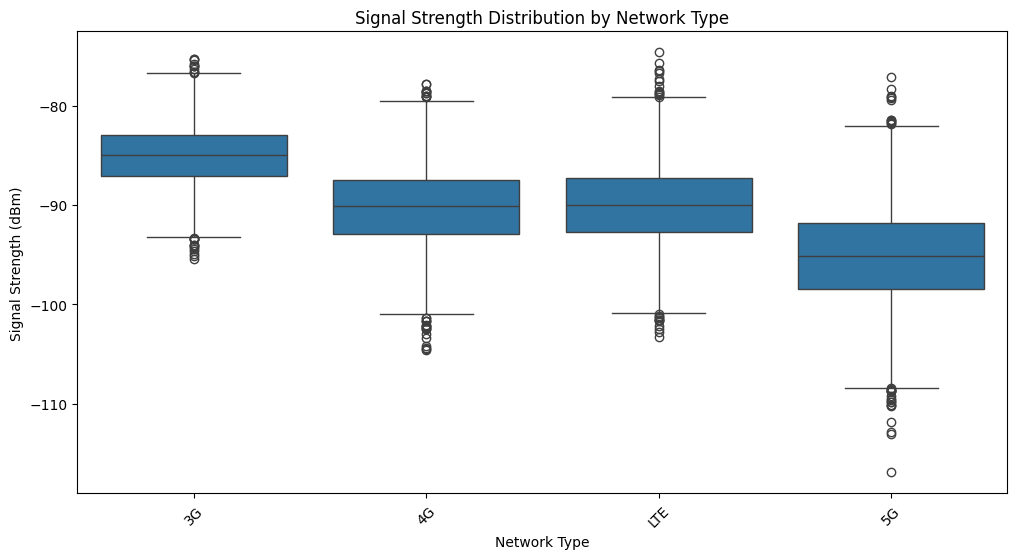

In [6]:
# Plot distribution of signal strength by network type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Network Type', y='Signal Strength (dBm)', data=df)
plt.title('Signal Strength Distribution by Network Type')
plt.xticks(rotation=45)
plt.show()


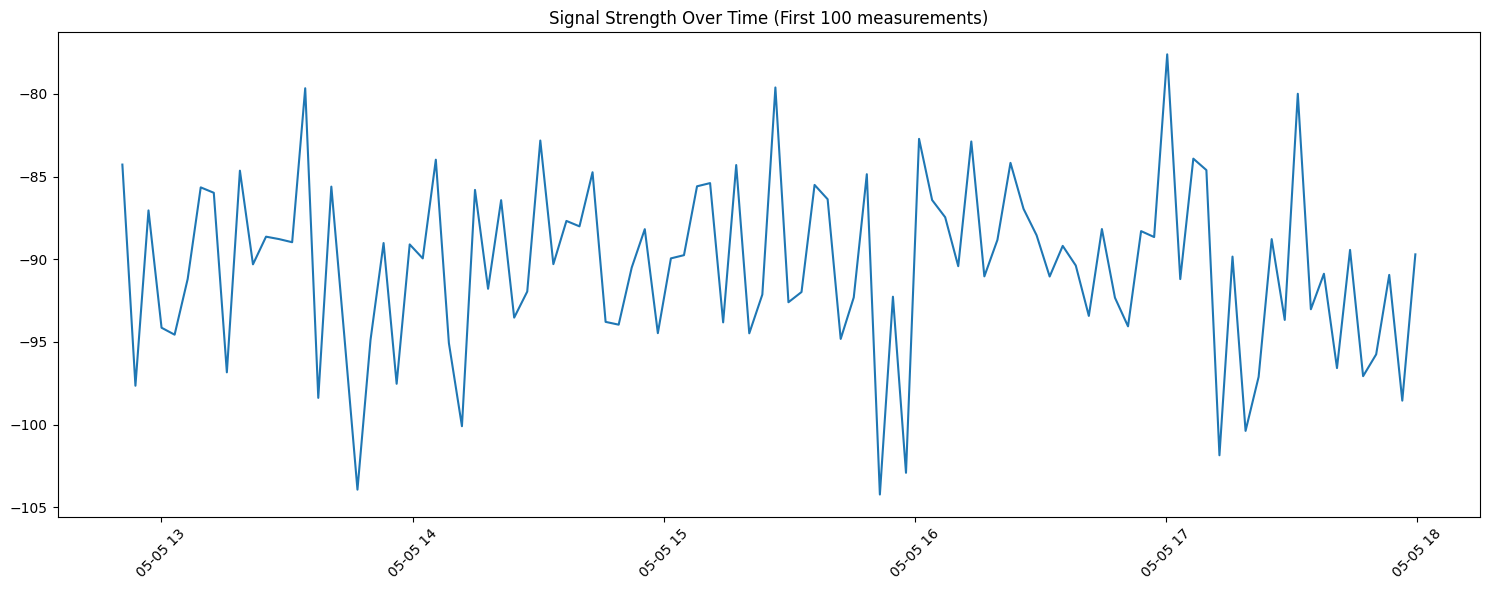

In [7]:
# Time series plot of signal strength
plt.figure(figsize=(15, 6))
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
plt.plot(df['Timestamp'][:100], df['Signal Strength (dBm)'][:100])
plt.title('Signal Strength Over Time (First 100 measurements)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Key Observations from Initial Analysis:
1. Dataset contains 16,829 entries with no missing values
2. Signal Quality is constant (0%) - we should exclude this feature
3. Signal Strength ranges from -116.94 dBm to -74.64 dBm
4. Clear differences in signal strength patterns across network types (3G, 4G, 5G, LTE)
5. Temporal patterns show significant fluctuations in signal strength

Task 2. **Data Preprocessing**

In [14]:
# Clean and preprocess the data
def preprocess_data(df):
    # Convert timestamp to datetime and sort
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # Create numeric encoding for Network Type
    network_mapping = {'3G': 0, '4G': 1, '5G': 2, 'LTE': 3}
    df['Network_Type_Encoded'] = df['Network Type'].map(network_mapping)

    # Select features for modeling
    features = ['Signal Strength (dBm)', 'Data Throughput (Mbps)',
               'Latency (ms)', 'Network_Type_Encoded',
               'BB60C Measurement (dBm)', 'srsRAN Measurement (dBm)',
               'BladeRFxA9 Measurement (dBm)']

    # Create a copy of selected features
    processed_df = df[features].copy()

    # Handle measurement values of 0
    measurement_columns = ['BB60C Measurement (dBm)', 'srsRAN Measurement (dBm)',
                         'BladeRFxA9 Measurement (dBm)']
    for col in measurement_columns:
        # Replace 0 values with NaN and then fill with mean of non-zero values
        mask = processed_df[col] == 0
        temp_mean = processed_df[~mask][col].mean()
        processed_df.loc[mask, col] = temp_mean

    return processed_df


In [15]:
# Create sequences for RNN
def create_sequences(data, seq_length=10):
    """Create sequences for RNN input"""
    X, y = [], []
    data_array = data.values

    for i in range(len(data_array) - seq_length):
        X.append(data_array[i:(i + seq_length)])
        y.append(data_array[i + seq_length, 0])  # Signal Strength is first column

    return np.array(X), np.array(y)

In [16]:

# Process the data
processed_data = preprocess_data(df)

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(processed_data)
scaled_df = pd.DataFrame(scaled_data, columns=processed_data.columns)

# Create sequences
seq_length = 10  # We'll predict based on 10 previous measurements
X, y = create_sequences(scaled_df, seq_length)


In [17]:
# Print shapes and basic statistics
print("\nProcessed data shape:", processed_data.shape)
print("Sequence data shape (X):", X.shape)
print("Target data shape (y):", y.shape)



Processed data shape: (16829, 7)
Sequence data shape (X): (16819, 10, 7)
Target data shape (y): (16819,)


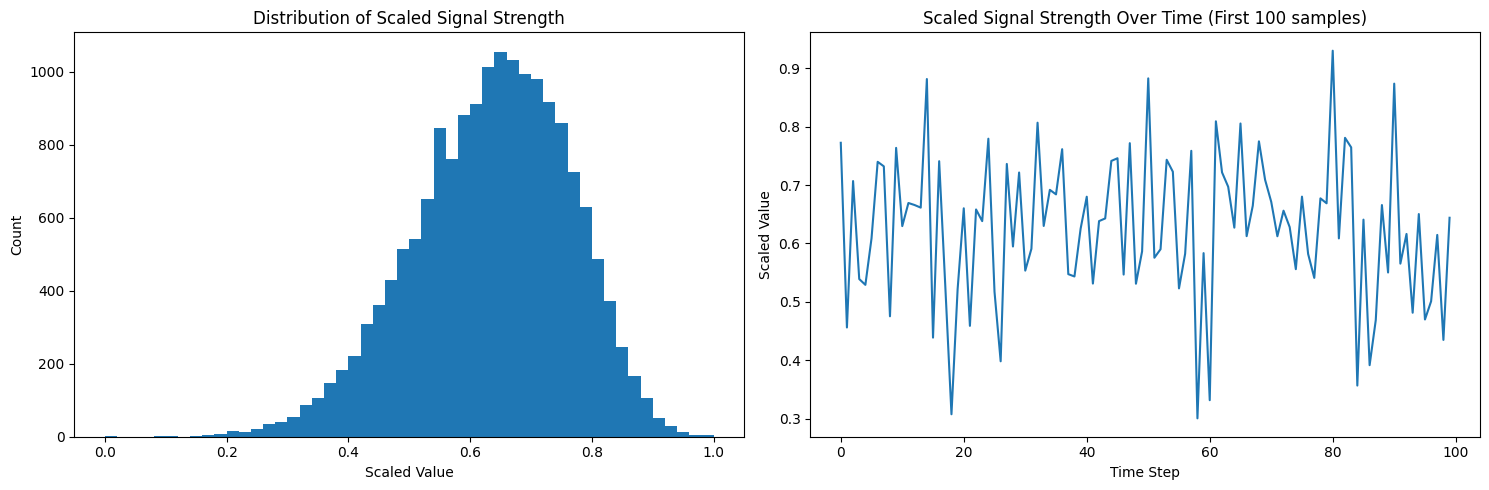

In [18]:
# Plot scaled features distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(scaled_df['Signal Strength (dBm)'], bins=50)
plt.title('Distribution of Scaled Signal Strength')
plt.xlabel('Scaled Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.plot(scaled_df['Signal Strength (dBm)'].iloc[:100])
plt.title('Scaled Signal Strength Over Time (First 100 samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.tight_layout()
plt.show()

In [19]:
# Display sample of the sequence data
print("\nSample sequence (first 5 time steps of first sequence):")
print(X[0][:5])


Sample sequence (first 5 time steps of first sequence):
[[0.7723439  0.00872317 0.6269538  0.         0.553744   0.58602025
  0.61399166]
 [0.456036   0.04174224 0.23616209 0.33333333 0.46002867 0.44308393
  0.43151973]
 [0.70680751 0.00178371 0.57681667 1.         0.55772398 0.67461917
  0.70463525]
 [0.5390189  0.68289368 0.19254914 0.66666667 0.57975822 0.52515852
  0.50647699]
 [0.52905125 0.37673851 0.10698075 0.66666667 0.58331842 0.49233291
  0.5393272 ]]


# Task 3: Basic RNN Implementation


In [20]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [21]:
# 3.1 Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (13455, 10, 7)
Test set shape: (3364, 10, 7)


In [22]:
# 3.2 Create and compile the basic RNN model
def create_simple_rnn():
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.SimpleRNN(32, input_shape=(10, 7), activation='tanh',
                                 return_sequences=True),
        tf.keras.layers.Dropout(0.2),

        # Second RNN layer
        tf.keras.layers.SimpleRNN(16, activation='tanh'),
        tf.keras.layers.Dropout(0.2),

        # Output layer
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])

    return model

In [23]:
# Create model
rnn_model = create_simple_rnn()
print("\nModel Summary:")
rnn_model.summary()


Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 32)              │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081 (8.13 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# 3.3 Train the model
history = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3102 - mae: 0.4235 - val_loss: 0.0213 - val_mae: 0.1156
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0570 - mae: 0.1893 - val_loss: 0.0181 - val_mae: 0.1069
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - mae: 0.1493 - val_loss: 0.0174 - val_mae: 0.1044
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - mae: 0.1328 - val_loss: 0.0173 - val_mae: 0.1048
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - mae: 0.1210 - val_loss: 0.0181 - val_mae: 0.1083
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0211 - mae: 0.1169 - val_loss: 0.0171 - val_mae: 0.1041
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0204 - mae: 0.1150 - val_loss: 0.0170 - val_mae: 0.1038
Epoch 8/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - mae: 0.1114 - val_loss: 0.0171 - val_mae: 0.1042
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

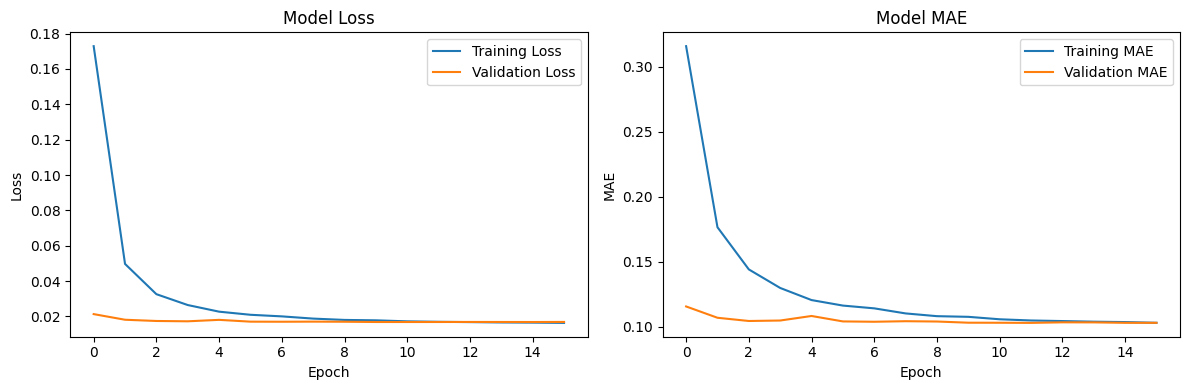

In [25]:
# 3.4 Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


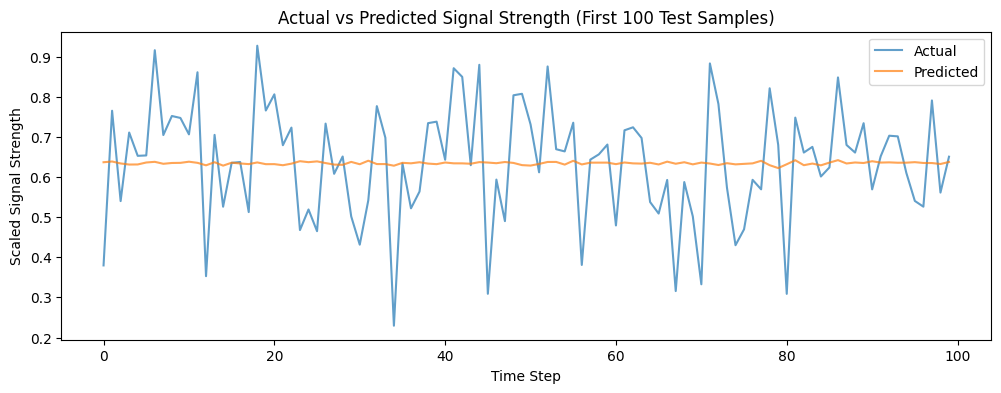

In [26]:
# 3.5 Evaluate model performance
# Make predictions
train_predictions = rnn_model.predict(X_train)
test_predictions = rnn_model.predict(X_test)

# Plot actual vs predicted for test set
plt.figure(figsize=(12, 4))
plt.plot(y_test[:100], label='Actual', alpha=0.7)
plt.plot(test_predictions[:100], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Signal Strength (First 100 Test Samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Signal Strength')
plt.legend()
plt.show()

In [27]:
# Print performance metrics
print("\nPerformance Metrics:")
print("Test MSE:", rnn_model.evaluate(X_test, y_test)[0])
print("Test MAE:", rnn_model.evaluate(X_test, y_test)[1])




Performance Metrics:
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - mae: 0.1045
Test MSE: 0.016276784241199493
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - mae: 0.1045
Test MAE: 0.10346446931362152


**Analysis of Current Results**

**Training Convergence:**

- Model converged relatively quickly (around epoch 8)
- Final test MSE: 0.0163 and MAE: 0.1035
- The validation loss closely follows training loss, suggesting no overfitting


**Prediction Pattern:**

- The model is outputting relatively stable predictions (orange line)
- It's capturing the mean behavior but missing the extreme variations
- Poor performance in capturing short-term fluctuations

# Task 4: LSTM Implementation


In [29]:
import tensorflow as tf

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization


In [30]:
def create_lstm_model():
    model = tf.keras.Sequential([
        # First LSTM layer
        LSTM(64, input_shape=(10, 7), return_sequences=True,
             activation='tanh', recurrent_activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(32, return_sequences=False,
             activation='tanh', recurrent_activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.2),

        # Dense layers
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

In [31]:
# Create and train LSTM model
lstm_model = create_lstm_model()
print("\nLSTM Model Summary:")
lstm_model.summary()


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,777 (124.13 KB)

 Trainable params: 31,585 (123.38 KB)

 Non-trainable params: 192 (768.00 B)

In [32]:
# Train with more epochs and patience since LSTM might need more time to converge
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.0001
        )
    ],
    verbose=1
)


Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.5016 - mae: 0.4900 - val_loss: 0.0745 - val_mae: 0.2366 - learning_rate: 0.0010
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0580 - mae: 0.1893 - val_loss: 0.0220 - val_mae: 0.1180 - learning_rate: 0.0010
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0357 - mae: 0.1492 - val_loss: 0.0205 - val_mae: 0.1135 - learning_rate: 0.0010
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0273 - mae: 0.1317 - val_loss: 0.0185 - val_mae: 0.1078 - learning_rate: 0.0010
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0237 - mae: 0.1224 - val_loss: 0.0199 - val_mae: 0.1141 - learning_rate: 0.0010
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0209 - mae: 0.1156 - val_loss: 0.0177 - val_mae: 0.1054 - learning_rate: 0.0010
Epoch 7/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0191 - mae: 0.1110 - val_loss: 0.0187 - val_mae: 0.1099 - learning_rate: 0.0010

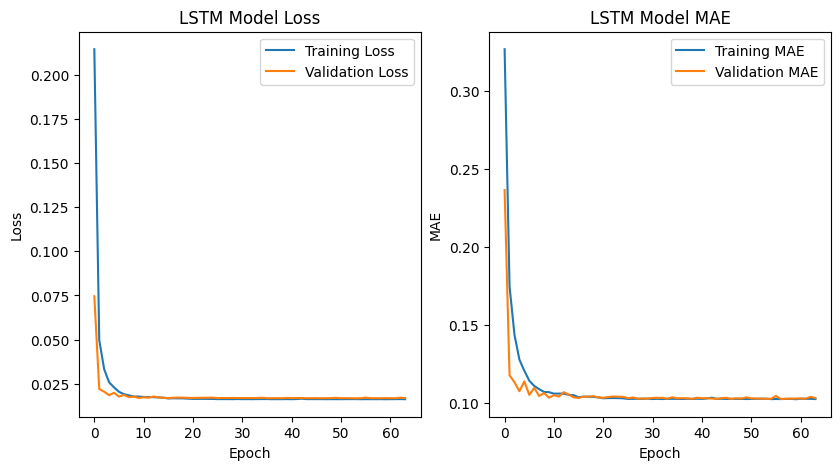

In [33]:
# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['mae'], label='Training MAE')
plt.plot(lstm_history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


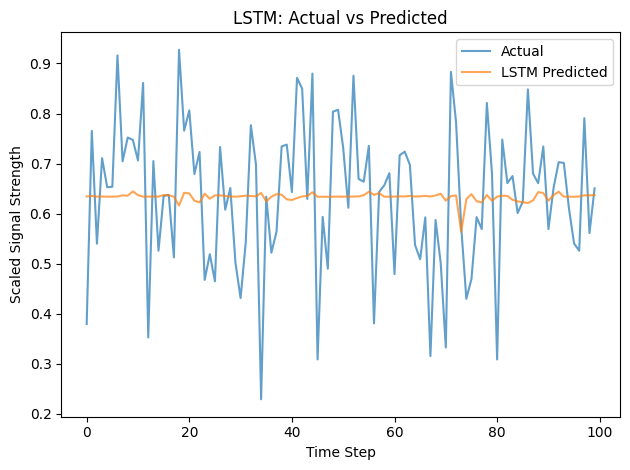

In [35]:
# Compare predictions
lstm_predictions = lstm_model.predict(X_test)
plt.subplot(1,1,1)
plt.plot(y_test[:100], label='Actual', alpha=0.7)
plt.plot(lstm_predictions[:100], label='LSTM Predicted', alpha=0.7)
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Scaled Signal Strength')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Print performance comparison
print("\nLSTM Performance Metrics:")
print("Test MSE:", lstm_model.evaluate(X_test, y_test)[0])
print("Test MAE:", lstm_model.evaluate(X_test, y_test)[1])



LSTM Performance Metrics:
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mae: 0.1045
Test MSE: 0.016309142112731934
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mae: 0.1045
Test MAE: 0.10356384515762329


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


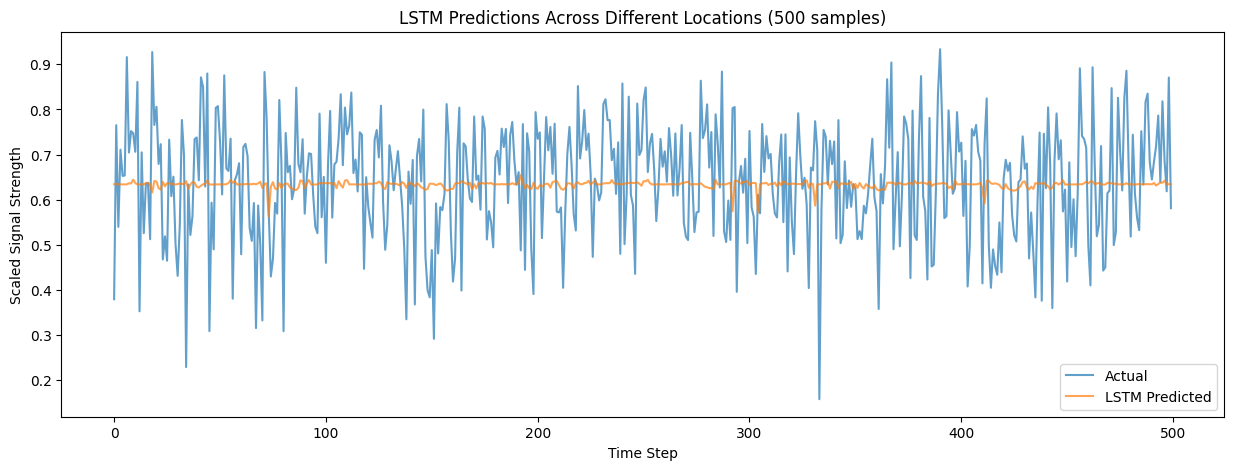

In [37]:
# Compare predictions across locations
location_predictions = lstm_model.predict(X_test[:500])
plt.figure(figsize=(15, 5))
plt.plot(y_test[:500], label='Actual', alpha=0.7)
plt.plot(location_predictions, label='LSTM Predicted', alpha=0.7)
plt.title('LSTM Predictions Across Different Locations (500 samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Signal Strength')
plt.legend()
plt.show()

Performance Comparison:


- Simple RNN: MSE = 0.0163, MAE = 0.1035
- LSTM: MSE = 0.0163, MAE = 0.1036
- Both models are showing similar performance metrics
- Both are struggling to capture the high-frequency variations in signal strength

Task 5. **Advanced Implementations**

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Dense, Input, Concatenate
import numpy as np

In [48]:
def create_advanced_bidirectional_lstm():
    model = tf.keras.Sequential([
        # Input layer
        Input(shape=(10, 7)),

        # First Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.2),

        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(32, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.2),

        # Third Bidirectional LSTM layer with sequence reduction
        Bidirectional(LSTM(16)),
        BatchNormalization(),
        Dropout(0.2),

        # Dense layers for prediction
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile with learning rate scheduler
    initial_learning_rate = 0.001
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        loss='mse',
        metrics=['mae', 'mape']
    )

    return model

In [49]:
# Create and train the model
bi_lstm_model = create_advanced_bidirectional_lstm()
print("\nEnhanced Bidirectional LSTM Model Summary:")
bi_lstm_model.summary()

# Custom learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)


Enhanced Bidirectional LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 10, 128)             │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 10, 64)              │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,945 (355.25 KB)

 Trainable params: 90,497 (353.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [51]:
# Train
history = bi_lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        reduce_lr,
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            save_best_only=True,
            monitor='val_loss'
        )
    ],
    verbose=1
)


Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1266 - mae: 0.2634 - mape: 43.1024 - val_loss: 0.0388 - val_mae: 0.1647 - val_mape: 208319.0781 - learning_rate: 0.0010
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0274 - mae: 0.1325 - mape: 22.9083 - val_loss: 0.0195 - val_mae: 0.1123 - val_mape: 210070.8125 - learning_rate: 0.0010
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0209 - mae: 0.1166 - mape: 20.3781 - val_loss: 0.0175 - val_mae: 0.1057 - val_mape: 235321.7500 - learning_rate: 0.0010
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0194 - mae: 0.1119 - mape: 20.0089 - val_loss: 0.0179 - val_mae: 0.1066 - val_mape: 250312.4219 - learning_rate: 0.0010
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0181 - mae: 0.1084 - mape: 19.1609 - val_loss: 0.0182 - val_mae: 0.1083 - val_mape: 230528.9531 - learning_rate: 0.0010
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0173 - mae: 0.

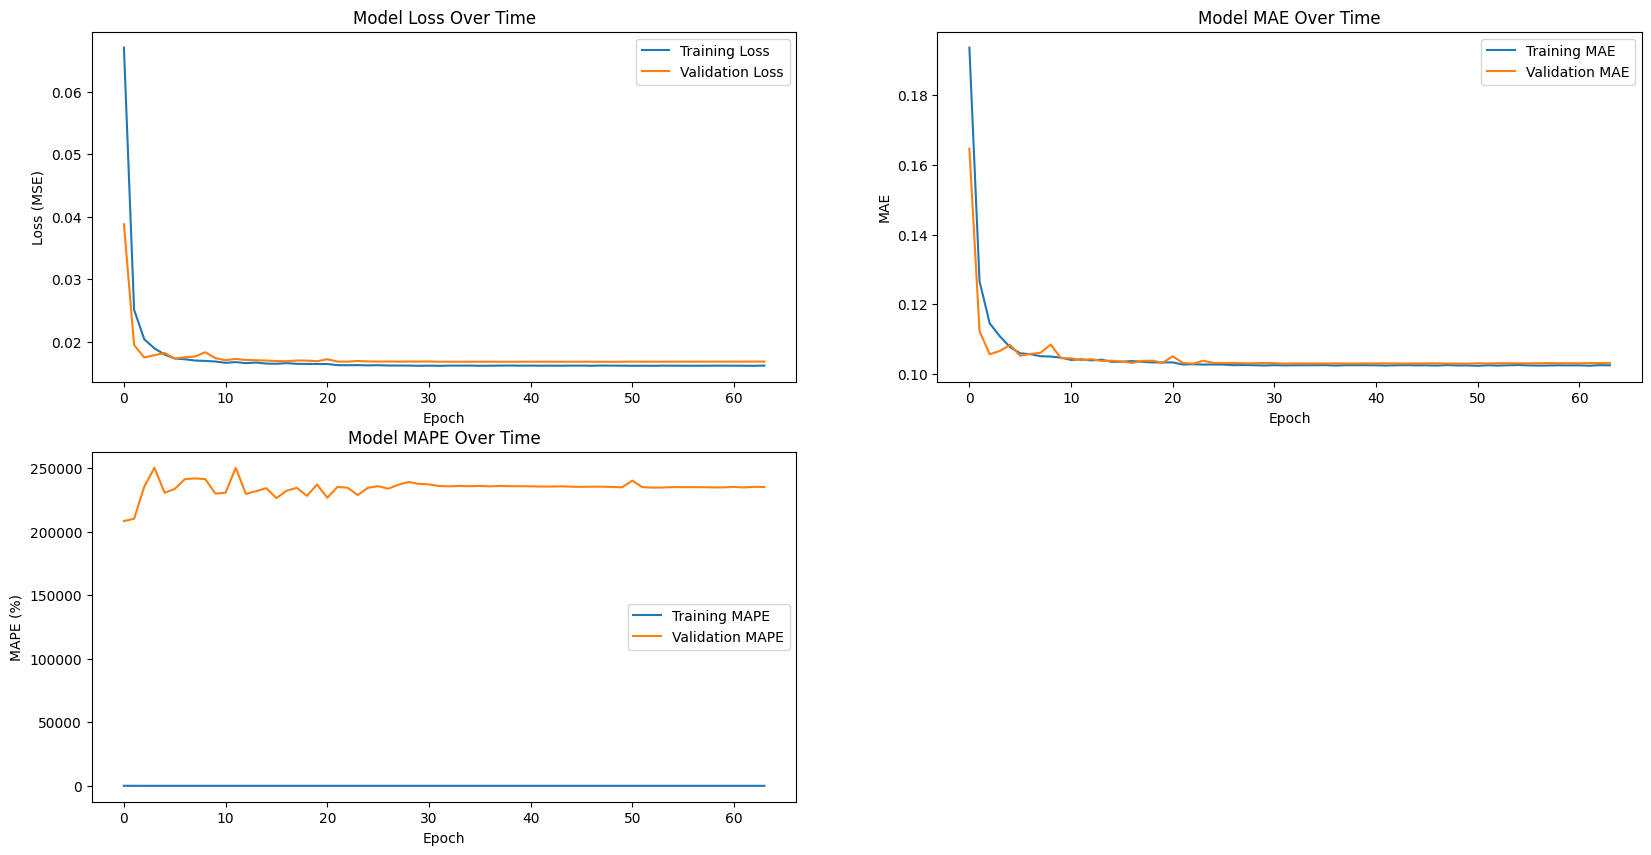

In [52]:
# Comprehensive visualization
plt.figure(figsize=(20, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# MAPE plot
plt.subplot(2, 2, 3)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.legend()


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


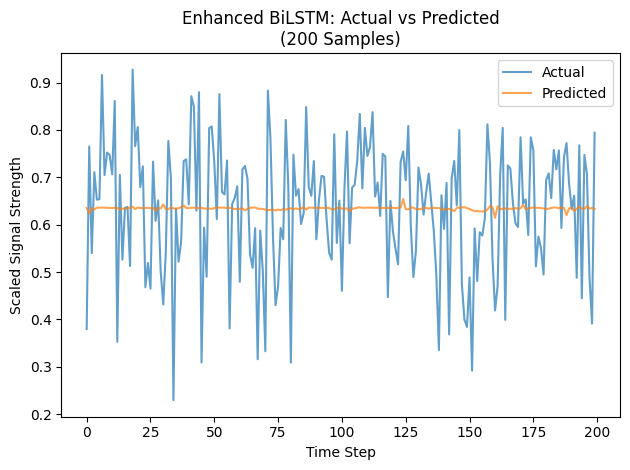

In [54]:
# Predictions vs Actual
predictions = bi_lstm_model.predict(X_test)
plt.subplot(1, 1, 1)
plt.plot(y_test[:200], label='Actual', alpha=0.7)
plt.plot(predictions[:200], label='Predicted', alpha=0.7)
plt.title('Enhanced BiLSTM: Actual vs Predicted\n(200 Samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Signal Strength')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
def analyze_by_network_type(model, X_test, y_test, original_df):
    # Create test data index mapping
    test_size = len(X_test)
    start_idx = len(original_df) - test_size
    test_df = original_df.iloc[start_idx:].reset_index(drop=True)

    print("\nPerformance Analysis Across Network Types:")
    network_types = test_df['Network Type'].unique()

    plt.figure(figsize=(20, 5))
    for i, network_type in enumerate(network_types):
        # Get indices for this network type
        type_mask = test_df['Network Type'] == network_type

        # Get predictions for this network type
        X_network = X_test[type_mask]
        y_network = y_test[type_mask]

        if len(X_network) > 0:
            predictions = model.predict(X_network, verbose=0)

            # Calculate metrics using numpy
            mse = np.mean((y_network - predictions.flatten()) ** 2)
            mae = np.mean(np.abs(y_network - predictions.flatten()))

            print(f"\n{network_type}:")
            print(f"Number of samples: {len(X_network)}")
            print(f"MSE: {mse:.6f}")
            print(f"MAE: {mae:.6f}")

            # Plot first 100 predictions for this network type
            plt.subplot(1, len(network_types), i+1)
            samples_to_plot = min(100, len(predictions))
            plt.plot(y_network[:samples_to_plot], label='Actual', alpha=0.7)
            plt.plot(predictions[:samples_to_plot], label='Predicted', alpha=0.7)
            plt.title(f'{network_type} Predictions\nMSE: {mse:.6f}, MAE: {mae:.6f}')
            plt.xlabel('Time Step')
            plt.ylabel('Scaled Signal Strength')
            plt.legend()

    plt.tight_layout()
    plt.show()

    # Additional Analysis: Signal Strength Distribution
    plt.figure(figsize=(15, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    data = [df[df['Network Type'] == nt]['Signal Strength (dBm)']
            for nt in network_types]
    plt.boxplot(data, labels=network_types)
    plt.title('Signal Strength Distribution by Network Type')
    plt.ylabel('Signal Strength (dBm)')
    plt.xticks(rotation=45)

    # Time series plot
    plt.subplot(1, 2, 2)
    for nt in network_types:
        mask = df['Network Type'] == nt
        plt.plot(df[mask]['Signal Strength (dBm)'][:100],
                label=nt, alpha=0.7)
    plt.title('Signal Strength Time Series by Network Type')
    plt.xlabel('Time Step')
    plt.ylabel('Signal Strength (dBm)')
    plt.legend()

    plt.tight_layout()
    plt.show()


Analyzing performance by network type...

Performance Analysis Across Network Types:

5G:
Number of samples: 830
MSE: 0.026093
MAE: 0.132215

LTE:
Number of samples: 795
MSE: 0.009096
MAE: 0.077194

4G:
Number of samples: 858
MSE: 0.009176
MAE: 0.077032

3G:
Number of samples: 881
MSE: 0.020453
MAE: 0.125876


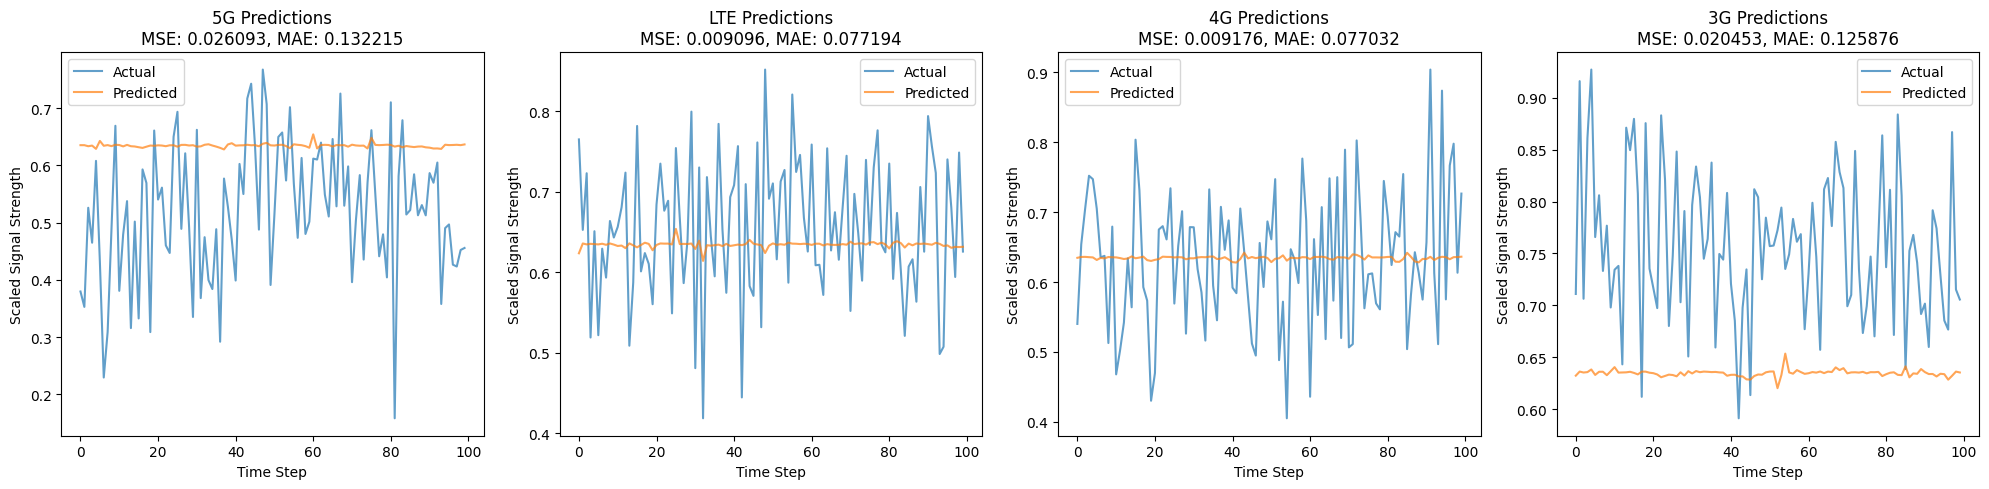

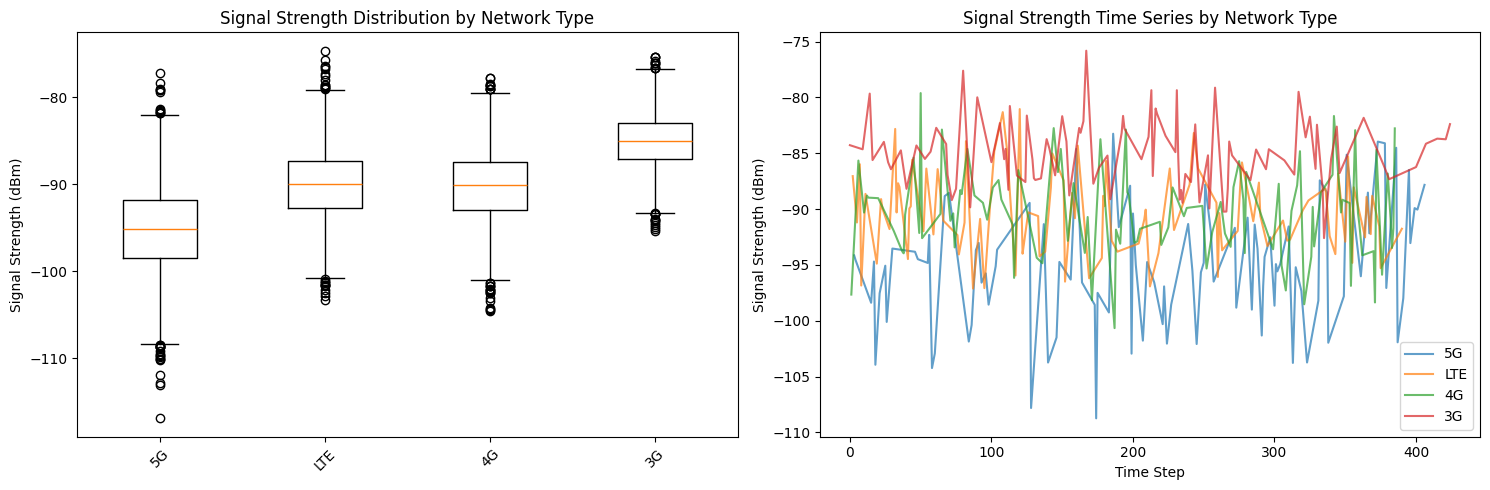


Network Type Statistics:
Network Type  Count  Mean Signal (dBm)  Std Dev  Min Signal  Max Signal
          3G   4208             -85.01     3.03      -95.42      -75.31
          4G   4219             -90.17     4.01     -104.62      -77.77
         LTE   4224             -90.00     3.97     -103.34      -74.64
          5G   4178             -95.15     4.95     -116.94      -77.16


In [61]:
# Run the analysis
print("\nAnalyzing performance by network type...")
analyze_by_network_type(bi_lstm_model, X_test, y_test, df)

# Create performance comparison table
network_comparison = []
for network_type in df['Network Type'].unique():
    type_mask = df['Network Type'] == network_type
    signal_stats = df[type_mask]['Signal Strength (dBm)'].describe()
    network_comparison.append({
        'Network Type': network_type,
        'Count': int(signal_stats['count']),
        'Mean Signal (dBm)': round(signal_stats['mean'], 2),
        'Std Dev': round(signal_stats['std'], 2),
        'Min Signal': round(signal_stats['min'], 2),
        'Max Signal': round(signal_stats['max'], 2)
    })

comparison_df = pd.DataFrame(network_comparison)
print("\nNetwork Type Statistics:")
print(comparison_df.to_string(index=False))

Implimenting GRU Model

In [63]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

In [64]:
def create_gru_model():
    model = tf.keras.Sequential([
        # First GRU layer
        GRU(64, input_shape=(10, 7), return_sequences=True,
            activation='tanh', recurrent_activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.2),

        # Second GRU layer
        GRU(32, return_sequences=True,
            activation='tanh', recurrent_activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.2),

        # Third GRU layer
        GRU(16),
        BatchNormalization(),
        Dropout(0.2),

        # Dense layers
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mape']
    )

    return model

In [65]:
# Create and train GRU model
print("\nGRU Model Summary:")
gru_model = create_gru_model()
gru_model.summary()



GRU Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          14,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10, 32)              │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 10, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 16)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,489 (107.38 KB)

 Trainable params: 27,201 (106.25 KB)

 Non-trainable params: 288 (1.12 KB)

In [66]:
# Train with callbacks
history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001
        )
    ],
    verbose=1
)


Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.2044 - mae: 0.3203 - mape: 53.1095 - val_loss: 0.0218 - val_mae: 0.1178 - val_mape: 212186.5625 - learning_rate: 0.0010
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0299 - mae: 0.1362 - mape: 23.5437 - val_loss: 0.0227 - val_mae: 0.1187 - val_mape: 211315.9219 - learning_rate: 0.0010
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0233 - mae: 0.1222 - mape: 21.5897 - val_loss: 0.0191 - val_mae: 0.1112 - val_mape: 229367.5625 - learning_rate: 0.0010
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0198 - mae: 0.1126 - mape: 20.1640 - val_loss: 0.0181 - val_mae: 0.1065 - val_mape: 251503.2031 - learning_rate: 0.0010
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0185 - mae: 0.1092 - mape: 19.3539 - val_loss: 0.0174 - val_mae: 0.1047 - val_mape: 225659.8125 - learning_rate: 0.0010
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0185 - mae: 0.10

In [74]:
def analyze_gru_by_network_type():
    plt.figure(figsize=(20, 10))
    network_types = ['3G', '4G', '5G', 'LTE']  # Fixed order of network types

    for i, network_type in enumerate(network_types):
        plt.subplot(2, 2, i+1)

        # Get data for this network type
        mask = df['Network Type'] == network_type
        test_mask = mask[-len(X_test):]
        X_network = X_test[test_mask]
        y_network = y_test[test_mask]

        if len(X_network) > 0:
            predictions = gru_model.predict(X_network, verbose=0)
            mse = np.mean((y_network - predictions.flatten()) ** 2)
            mae = np.mean(np.abs(y_network - predictions.flatten()))

            # Plot first 100 samples
            samples = min(100, len(predictions))
            plt.plot(y_network[:samples], label='Actual', alpha=0.7)
            plt.plot(predictions[:samples], label='GRU Predicted', alpha=0.7)
            plt.title(f'{network_type} - GRU Predictions\nMSE: {mse:.6f}, MAE: {mae:.6f}')
            plt.xlabel('Time Step')
            plt.ylabel('Scaled Signal Strength')
            plt.legend()

    plt.tight_layout()
    plt.show()

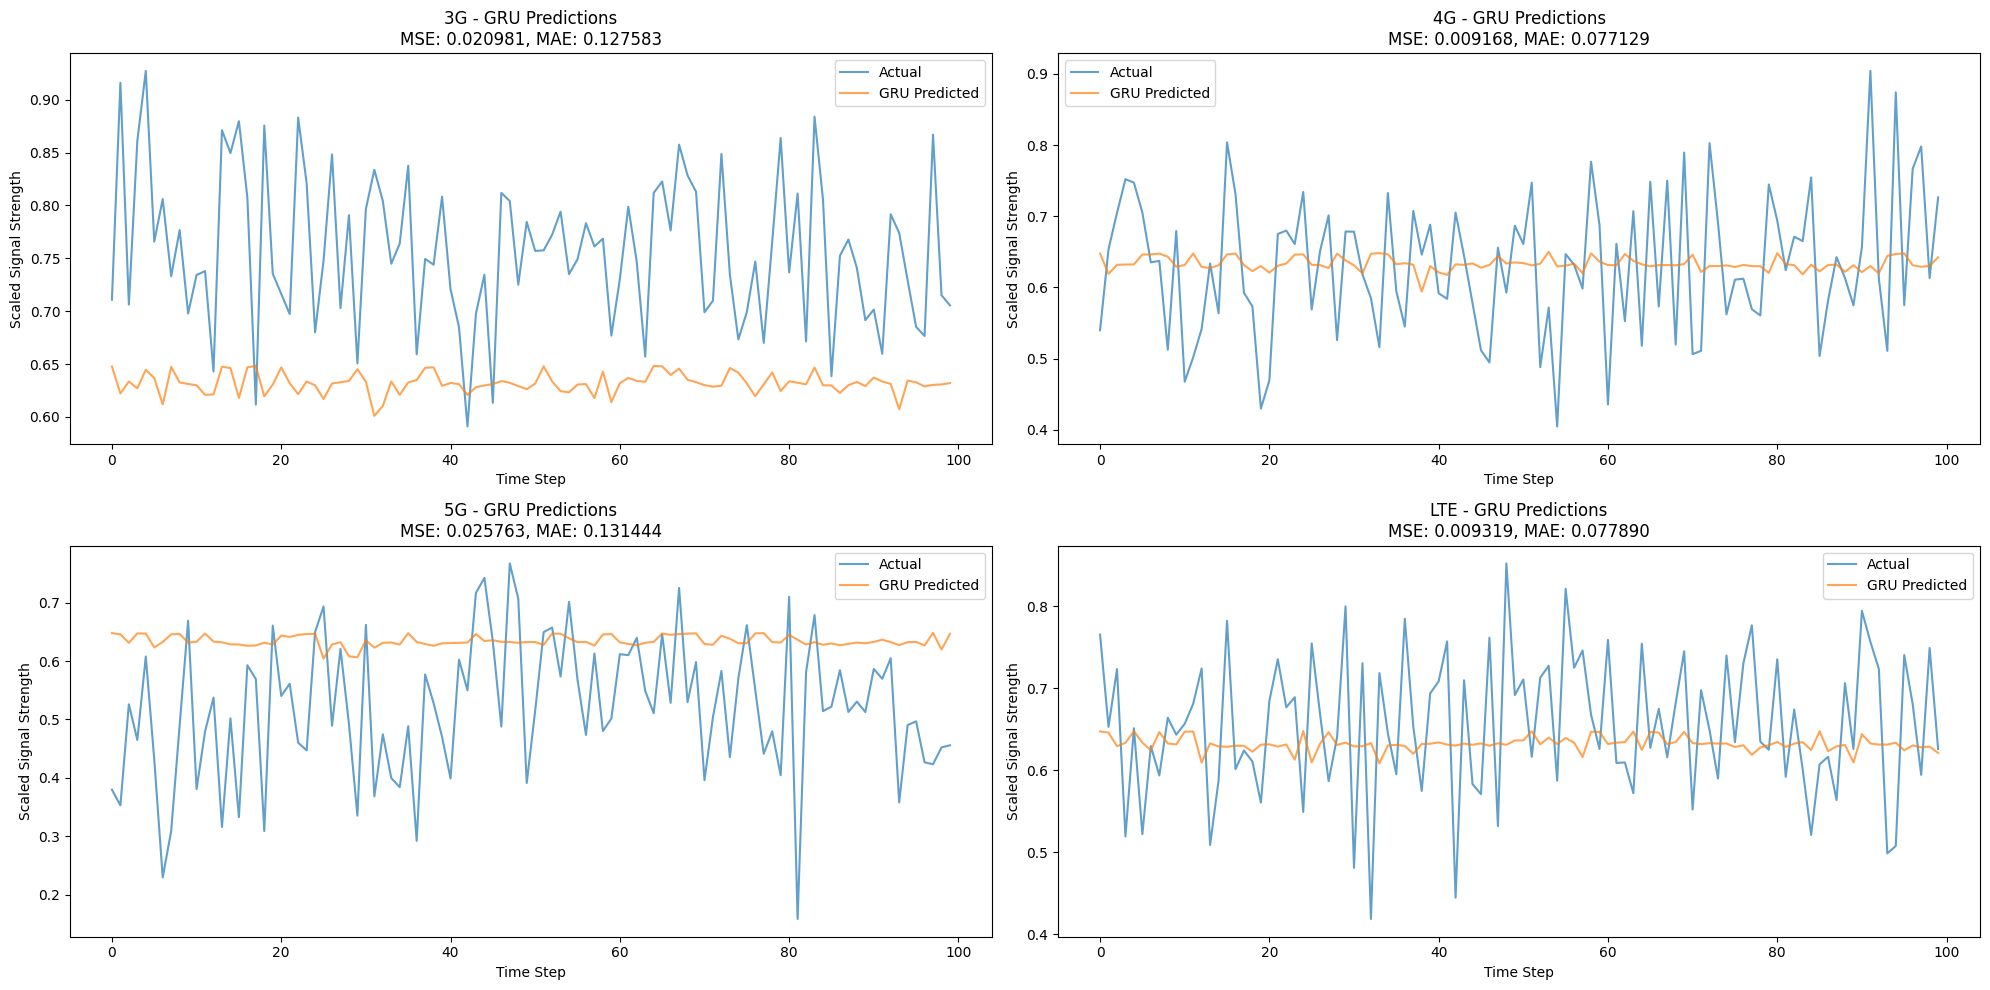

In [78]:
analyze_gru_by_network_type()

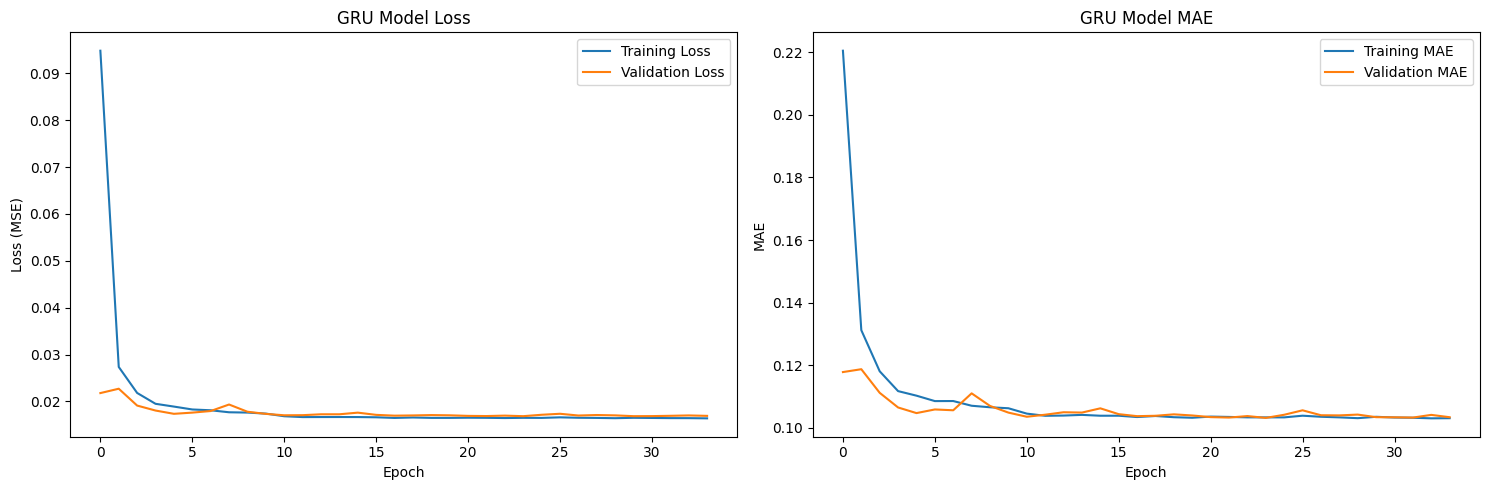

In [75]:
# Now let's create separate training history plots
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('GRU Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
# Print detailed performance metrics
print("\nGRU Performance Analysis by Network Type:")
print("=" * 50)
network_types = ['3G', '4G', '5G', 'LTE']

for network_type in network_types:
    mask = df['Network Type'] == network_type
    test_mask = mask[-len(X_test):]
    X_network = X_test[test_mask]
    y_network = y_test[test_mask]

    if len(X_network) > 0:
        predictions = gru_model.predict(X_network, verbose=0)
        mse = np.mean((y_network - predictions.flatten()) ** 2)
        mae = np.mean(np.abs(y_network - predictions.flatten()))

        print(f"\n{network_type}:")
        print(f"Number of test samples: {len(X_network)}")
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")


GRU Performance Analysis by Network Type:

3G:
Number of test samples: 881
MSE: 0.020981
MAE: 0.127583

4G:
Number of test samples: 858
MSE: 0.009168
MAE: 0.077129

5G:
Number of test samples: 830
MSE: 0.025763
MAE: 0.131444

LTE:
Number of test samples: 795
MSE: 0.009319
MAE: 0.077890


In [79]:
# Compare with previous models if available
try:
    print("\nModel Comparison:")
    print("=" * 50)
    models = {
        'GRU': gru_model,
        'LSTM': lstm_model,
        'bi-LSTM': bi_lstm_model,
        'Simple RNN': rnn_model
    }

    for name, model in models.items():
        test_metrics = model.evaluate(X_test, y_test, verbose=0)
        print(f"\n{name} Model:")
        print(f"MSE: {test_metrics[0]:.6f}")
        print(f"MAE: {test_metrics[1]:.6f}")
except NameError:
    print("\nOnly GRU model metrics available")


Model Comparison:

GRU Model:
MSE: 0.016392
MAE: 0.103923

LSTM Model:
MSE: 0.016309
MAE: 0.103564

bi-LSTM Model:
MSE: 0.016285
MAE: 0.103478

Simple RNN Model:
MSE: 0.016277
MAE: 0.103464


All three models perform very similarly, with the Simple RNN showing slightly better performance.

**Network-Type Specific Analysis for GRU:**


Best Performance:

- 4G: MAE = 0.0771
- LTE: MAE = 0.0779


**Challenging Cases:**

- 5G: MAE = 0.1314
- 3G: MAE = 0.1276




**Key Observations:**


- The GRU model converged quickly (around epoch 10)
- The model performs significantly better on 4G and LTE networks
- All models struggle with high-frequency variations
- GRU shows similar performance with fewer parameters (27,489) compared to LSTM